In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('train_norm.csv')

In [3]:
raw_data = raw_data.drop("Unnamed: 0", 1)

In [4]:
raw_data_y = raw_data[['fraud_ind']]

In [55]:
raw_data_y = raw_data_y.values.ravel()

In [56]:
x_train,x_val,y_train,y_val = train_test_split(raw_data.drop("fraud_ind", 1),
                                               raw_data_y,
                                               test_size = 0.2)

In [6]:
x_train

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd
756730,0.983295,0.788727,0.215835,0.116849,0.833333,0.826667,0.0,0.4,0.0,0.0,...,0.0,0.0,0.101124,0.730864,0.538126,0.755980,0.0,0.869435,0.953271,0.0
778319,0.876235,0.007884,0.159984,0.101292,0.666667,0.826667,0.0,0.2,0.0,0.0,...,0.0,0.0,0.865169,0.360902,0.544662,0.795445,0.0,0.871983,0.953271,0.0
502335,0.983004,0.648591,0.600331,0.089220,0.833333,0.826667,0.0,0.5,0.0,0.0,...,0.0,0.0,0.966292,0.815150,0.620915,0.175400,0.0,0.871983,0.953271,0.0
550046,0.999564,0.573519,0.967272,0.071274,0.833333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.078652,0.981221,0.995643,0.574685,0.0,0.000000,0.953271,0.0
333960,0.969930,0.395605,0.277752,0.051848,0.833333,0.826667,0.0,0.4,0.0,0.0,...,0.0,0.0,0.033708,0.777461,0.651416,0.265848,0.0,0.902713,0.953271,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261959,0.994044,0.294692,0.491553,0.036345,0.833333,0.826667,0.0,0.5,0.0,0.0,...,0.0,0.0,0.101124,0.854610,0.555556,0.322011,0.0,0.871983,0.953271,0.0
434297,0.985328,0.889317,0.430508,0.020125,0.833333,0.826667,0.0,0.5,0.0,0.0,...,0.0,0.0,0.842697,0.510288,0.555556,0.292846,0.0,0.894319,0.953271,0.0
684207,0.905142,0.828091,0.612265,0.055681,0.833333,0.826667,1.0,0.2,0.0,1.0,...,0.0,0.0,0.528090,0.608284,0.416122,0.197799,0.0,0.871983,0.953271,0.0
654232,0.992737,0.085378,0.282777,0.113763,0.833333,0.826667,0.0,0.4,0.0,0.0,...,0.0,0.0,0.191011,0.646922,0.599129,0.957970,0.0,0.871983,0.953271,0.0


In [7]:
#整合成Dataset

train_data = lgb.Dataset(x_train, label = y_train)

validation_data = lgb.Dataset(x_val, label = y_val)

In [8]:
params = {
'learning_rate': 0.03,
'feature_fraction': 0.7,
'bagging_fraction ': 0.8,
'reg_alpha': 0.1,
'reg_lambda': 0.2,
'max_depth': 50,
'num_leaves': 60,
'min_child_samples':21,
'min_child_weight':0.001,
'bagging_freq' : 2,
'cat_smooth': 0,
'objective': 'binary', 
'metric':'binary_logloss,auc',
}


In [9]:
# 訓練model 
train_results = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Info] Number of positive: 12252, number of negative: 696556
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 708808, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017285 -> initscore=-4.040459
[LightGBM] [Info] Start training from score -4.040459


In [10]:
#儲存 model
train_results.save_model('lightgbm_model.txt')

# Validation

In [11]:
predict = train_results.predict(x_val)

In [12]:
def f_score_cal(labels, preds):
    ((TN, FP), (FN, TP)) = confusion_matrix(labels, preds, labels=[0, 1])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * (precision * recall) / (precision + recall)
    return f_score

In [13]:
val_dist = [f_score_cal((predict > i / 100).astype(np.int32), y_val.values) for i in range(0, 99)]

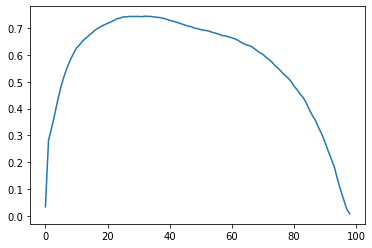

In [14]:
plt.plot(val_dist)

In [15]:
np.argmax(val_dist)

32

# Testing

In [18]:
import pickle

with open("preprocessor.pkt", "rb") as f:
    preprocessor = pickle.load(f)

raw_test_data = pd.read_csv("test.csv")
def preprocess_test_data(raw_test_data):
    labels = raw_test_data["fraud_ind"]
    df = raw_test_data.drop(["fraud_ind", "txkey"], 1)
    df = df.fillna("NA")
    
    for c in df.keys():
        if not (df[c].dtype == np.int64 or df[c].dtype == np.float64):
            df.loc[:,c] = preprocessor['les'][c].transform(df.loc[:,c])
    
    x = preprocessor['scaler'].transform(df)
    df = pd.DataFrame(data=x, index=df.index, columns=df.columns)
    df = pd.DataFrame(preprocessor['mms'].transform(df.values), index=df.index, columns=df.columns)
    
    df["fraud_ind"] = labels
    
    return df

test_data = preprocess_test_data(raw_test_data)
x_test, y_test = test_data.drop("fraud_ind", 1), test_data['fraud_ind']

In [19]:
predict = train_results.predict(x_test)

In [20]:
test_predict = (predict > 0.31).astype(np.int32)

In [21]:
f_score_cal(y_test, test_predict)

0.7161054606497482

# GridSearch

In [26]:
from sklearn.model_selection import GridSearchCV

In [57]:
# 使用sklearn套件 :　LGBMClassifier + GridSearch 參考 https://zhuanlan.zhihu.com/p/76206257
# 第一步，这两个参数基本可以确定树的大小及复杂度，可以同时调整
# 對rae_data_y使用.values.ravel()，可解決DataConversionWarning: A column-vector y was passed when a 1d array was expected. 
# Please change the shape of y to (n_samples, ), for example using ravel().的 warning

parameters = {
    'max_depth': [30, 40, 50, 60, 70],
    'num_leaves': [40, 50, 60, 70, 80],
}

model = lgb.LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 50,
                         num_leaves = 60,
                         learning_rate = 0.03,
                         feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.1,
                         reg_lambda = 0.2,
                         cat_smooth = 0,
                        )

gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)

gsearch.fit(x_train, y_train)

print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

In [58]:
#第2步 : 该步骤主要是防止树过拟合
parameters2 = {
'min_child_samples': [18,19,20,21,22],
'min_child_weight': [0.001,0.002,0,0.1],
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 30,
                         num_leaves = 80,
                         learning_rate = 0.03,
                         feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.1,
                         reg_lambda = 0.2,
                         cat_smooth = 0,   
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters2, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

In [59]:
#第3步 : 该步骤主要是通过随机选择一定比列的特征去模型中，防止过拟合
parameters3 = {
    'feature_fraction': [0.6, 0.8, 1],
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         metric = 'binary_logloss,auc',
                         max_depth = 30,
                         num_leaves = 80,
                         learning_rate = 0.03,
                         feature_fraction = 0.8,
                         min_child_samples=19,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.1,
                         reg_lambda = 0.2,
                         cat_smooth = 0,    
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters3, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

In [63]:
#第4步 : bagging_fraction+bagging_freq参数必须同时设置，bagging_fraction相当于subsample样本采样，
#可以使bagging更快的运行，同时也可以降拟合。bagging_freq默认0，表示bagging的频率，0意味着没有使用bagging，
#k意味着每k轮迭代进行一次bagging。
parametersˋ = {
     'bagging_fraction': [0.8,0.9,1],
     'bagging_freq': [2,3,4],
}
gbm = lgb.LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 50,
                         num_leaves = 60,
                         learning_rate = 0.03,
                         feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.1,
                         reg_lambda = 0.2,
                         cat_smooth = 0,
                        )

gsearch = GridSearchCV(gbm, param_grid=parametersˋ, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be 

In [64]:
#第5步 : 调整lambda_l1(reg_alpha)和lambda_l2(reg_lambda)
#本步骤通过L1正则化和L2正则化降低过拟合
parameters5 = {
     'reg_lambda': [8,0.2,4,0.1],
     'reg_alpha': [0.001,0.005,0.1,0.2],
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 50,
                         num_leaves = 60,
                         learning_rate = 0.03,
                         feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.1,
                         reg_lambda = 0.2,
                         cat_smooth = 0,
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters5, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

参数的最佳取值:{'reg_alpha': 0.001, 'reg_lambda': 0.1}
最佳模型得分:0.9792975436119816
[0.97889996 0.97928684 0.97925345 0.97929754 0.97890436 0.97923173
 0.97925459 0.97927682 0.97888218 0.97926753 0.97919264 0.9791793
 0.97885992 0.97927302 0.97926786 0.9791874 ]
[{'reg_alpha': 0.001, 'reg_lambda': 8}, {'reg_alpha': 0.001, 'reg_lambda': 0.2}, {'reg_alpha': 0.001, 'reg_lambda': 4}, {'reg_alpha': 0.001, 'reg_lambda': 0.1}, {'reg_alpha': 0.005, 'reg_lambda': 8}, {'reg_alpha': 0.005, 'reg_lambda': 0.2}, {'reg_alpha': 0.005, 'reg_lambda': 4}, {'reg_alpha': 0.005, 'reg_lambda': 0.1}, {'reg_alpha': 0.1, 'reg_lambda': 8}, {'reg_alpha': 0.1, 'reg_lambda': 0.2}, {'reg_alpha': 0.1, 'reg_lambda': 4}, {'reg_alpha': 0.1, 'reg_lambda': 0.1}, {'reg_alpha': 0.2, 'reg_lambda': 8}, {'reg_alpha': 0.2, 'reg_lambda': 0.2}, {'reg_alpha': 0.2, 'reg_lambda': 4}, {'reg_alpha': 0.2, 'reg_lambda': 0.1}]


In [62]:
#第6步 : cat_smooth为设置每个类别拥有最小的个数，主要用于去噪。
parameters6 = {
     'cat_smooth': [0,10,20],
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 30,
                         num_leaves = 80,
                         learning_rate = 0.03,
                         feature_fraction = 0.8,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 3,
                         reg_alpha = 0.001,
                         reg_lambda = 0.1,
                         cat_smooth = 0,    
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters6, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

# Analysis

In [37]:
y_test_p_ind       = np.where(y_test       == 1)[0]
y_test_n_ind       = np.where(y_test       == 0)[0]
test_predict_p_ind = np.where(test_predict == 1)[0]
test_predict_n_ind = np.where(test_predict == 0)[0]
TP_ind = np.array([ele for ele in y_test_p_ind if (ele in test_predict_p_ind)])
TN_ind = np.array([ele for ele in y_test_n_ind if (ele in test_predict_n_ind)])
FP_ind = np.array([ele for ele in y_test_n_ind if (ele in test_predict_p_ind)])
FN_ind = np.array([ele for ele in y_test_p_ind if (ele in test_predict_n_ind)])

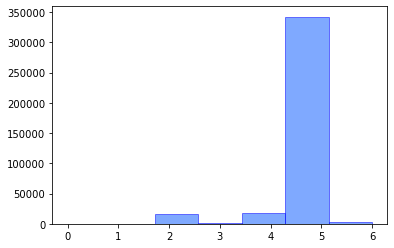

In [38]:
x_P  = x_test.iloc[y_test_p_ind]
x_N  = x_test.iloc[y_test_n_ind]
x_FP = x_test.iloc[FP_ind]
x_FN = x_test.iloc[FN_ind]
#print(set(x_P['contp']))
#print('contp of FP:', set(6*x_FP['contp']))
#print('contp of FN:', set(6*x_FN['contp']))
#min(x_FP['contp'])
plt.hist(raw_test_data['contp'], bins=7, color='#0055FF', ec='#0000FF', alpha=0.5)
#print(set(raw_test_data['contp']))
plt.show()
#2,3,6容易被忽略；5很多容易錯，4不知道

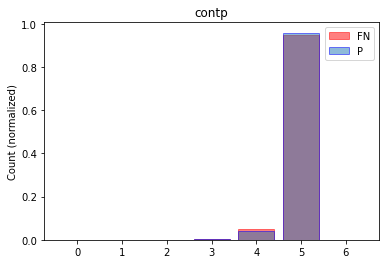

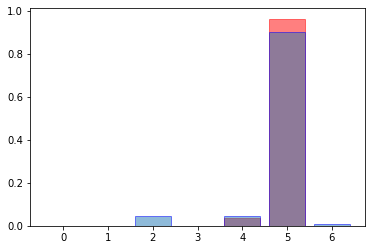

In [39]:
y = []
x = [int(ele+0.0001) for ele in x_FN['contp']*6]
for i in range(0,7):
    y.append(x.count(i)/len(x))
plt.bar(['0','1','2','3','4','5','6'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_P['contp']*6]
for i in range(0,7):
    y.append(x.count(i)/len(x))
plt.bar(['0','1','2','3','4','5','6'],y,ec='#0000ff',alpha=0.5)
plt.title('contp')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('contp_FN.png')
plt.show()

y = []
x = [int(ele+0.0001) for ele in x_FP['contp']*6]
for i in range(0,7):
    y.append(x.count(i)/len(x))
plt.bar(['0','1','2','3','4','5','6'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_N['contp']*6]
for i in range(0,7):
    y.append(x.count(i)/len(x))
plt.bar(['0','1','2','3','4','5','6'],y,ec='#0000ff',alpha=0.5)
plt.show()

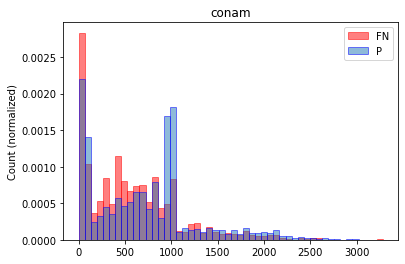

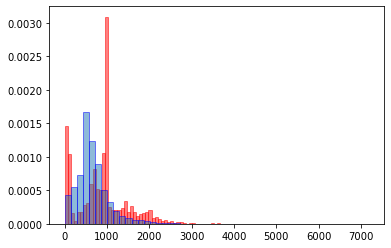

In [40]:
#很多FP都分布在0.2，而他們本來在N裡，peakN比peakFP偏左了一點
b = max(raw_test_data['conam'])
a = min(raw_test_data['conam'])

plt.hist(x_FN['conam']*(b-a)+a,color='r',ec='#FF0000', alpha=0.5,density=True,bins=50)
plt.hist(x_P['conam' ]*(b-a)+a,ec='#0000FF', alpha=0.5, density=True,bins=50)
plt.title('conam')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('conam_FN.png')
plt.show()

plt.hist(x_FP['conam']*(b-a)+a,color='r',ec='#FF0000', alpha=0.5,density=True,bins=50)
plt.hist(x_N['conam' ]*(b-a)+a,ec='#0000FF', alpha=0.5,density=True,bins=50)
plt.show()

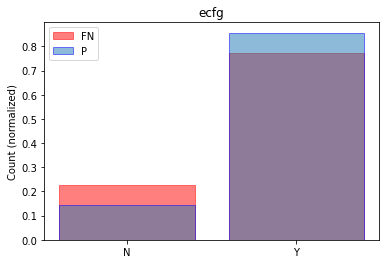

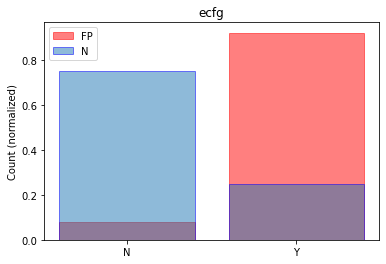

In [41]:
y = []
x = [int(ele) for ele in x_FN['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele) for ele in x_P['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,ec='#0000ff',alpha=0.5)

plt.title('ecfg')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('ecfg_FN.png')
plt.show()


y = []
x = [int(ele) for ele in x_FP['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele) for ele in x_N['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,ec='#0000ff',alpha=0.5)

plt.title('ecfg')
plt.legend(['FP','N'])
plt.ylabel('Count (normalized)')
plt.savefig('ecfg_FP.png')
plt.show()
#網路交易較常被誤認為盜刷

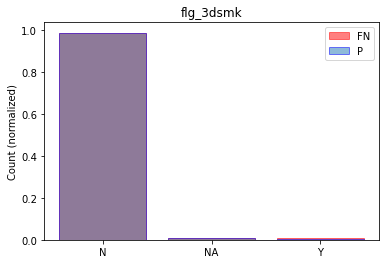

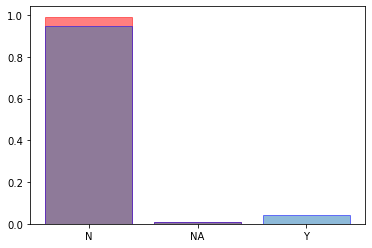

In [42]:
y = []
x = [int(ele+0.0001) for ele in x_FN['flg_3dsmk']*2]
for i in range(0,3):
    y.append(x.count(i)/len(x))
plt.bar(['N','NA','Y'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_P['flg_3dsmk']*2]
for i in range(0,3):
    y.append(x.count(i)/len(x))
plt.bar(['N','NA','Y'],y,ec='#0000ff',alpha=0.5)
plt.title('flg_3dsmk')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('flg_3dsmkFN.png')
plt.show()


y = []
x = [int(ele+0.0001) for ele in x_FP['flg_3dsmk']*2]
for i in range(0,3):
    y.append(x.count(i)/len(x))
plt.bar(['N','NA','Y'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_N['flg_3dsmk']*2]
for i in range(0,3):
    y.append(x.count(i)/len(x))
plt.bar(['N','NA','Y'],y,ec='#0000ff',alpha=0.5)

plt.show()

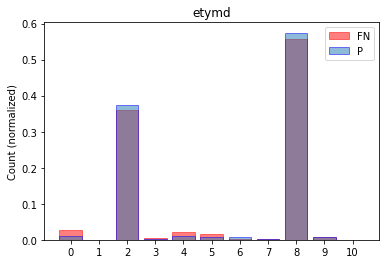

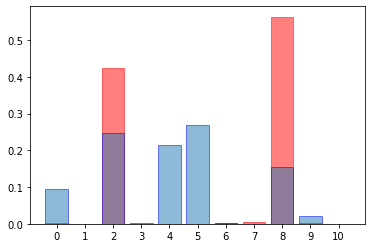

In [43]:
y = []
x = [int(ele) for ele in x_FN['etymd']*10]
for i in range(11):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(11)],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele) for ele in x_P['etymd']*10]
for i in range(11):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(11)],y,ec='#0000ff',alpha=0.5)
plt.title('etymd')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('etymd_FN.png')
plt.show()

y = []
x = [int(ele) for ele in x_FP['etymd']*10]
for i in range(11):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(11)],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele) for ele in x_N['etymd']*10]
for i in range(11):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(11)],y,ec='#0000ff',alpha=0.5)

plt.show()

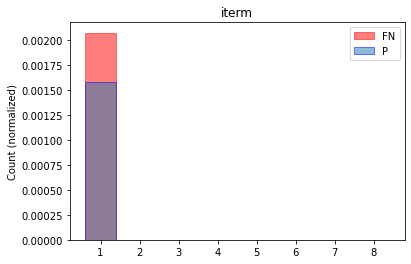

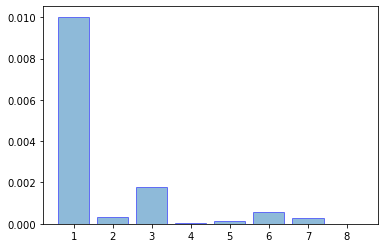

In [44]:
b = max(raw_test_data['iterm'])
a = min(raw_test_data['iterm'])
#print(set(x_test['iterm']*8))

y = []
x = [int(ele) for ele in x_FN['iterm']*8]
for i in range(9):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(1,9)],y[1:],color='r',ec='#ff0000',alpha=0.5)
#plt.show()

y = []
x = [int(ele) for ele in x_P['iterm']*8]
for i in range(9):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(1,9)],y[1:],ec='#0000ff',alpha=0.5)
plt.title('iterm')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

y = []
x = [int(ele) for ele in x_FP['iterm']*8]
for i in range(9):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(1,9)],y[1:],color='r',ec='#ff0000',alpha=0.5)
#plt.ylim([0,0.01])
#plt.show()

y = []
x = [int(ele) for ele in x_N['iterm']*8]
for i in range(9):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(1,9)],y[1:],ec='#0000ff',alpha=0.5)

plt.show()

1


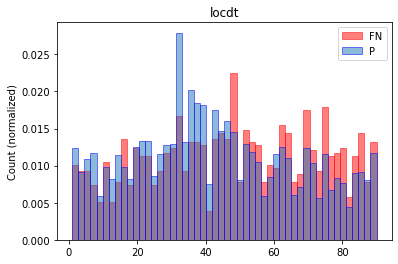

In [45]:
print(min(raw_test_data['locdt']))
plt.hist(x_FN['locdt']*89+1,color='r',bins=50,ec='#FF0000', alpha=0.5,density=True)
#plt.show()
plt.hist(x_P['locdt']*89+1,bins=50,ec='#0000FF', alpha=0.5,density=True)
plt.title('locdt')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('locdt_FN.png')
plt.show()

235959.0


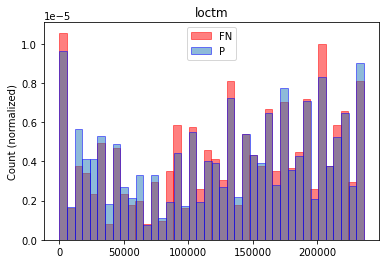

In [46]:
print(max(raw_test_data['loctm']))
plt.hist(x_FN['loctm']*235958+1,color='r',bins=40,ec='#FF0000', alpha=0.5,density=True)
#plt.show()
plt.hist(x_P['loctm']*235958+1,bins=40,ec='#0000FF', alpha=0.5,density=True)
plt.title('loctm')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.savefig('loctm_FN.png')
plt.show()

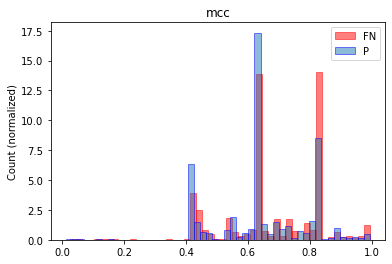

In [47]:
plt.hist(x_FN['mcc'],bins=50,color='r',ec='#FF0000', alpha=0.5,density=True)
plt.hist(x_P['mcc'],bins=50,ec='#0000FF', alpha=0.5,density=True)
plt.title('mcc')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

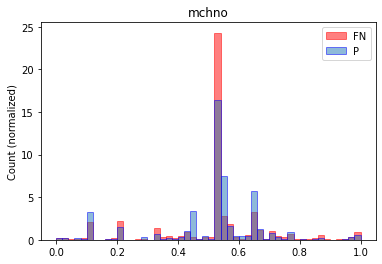

In [48]:
plt.hist(x_FN['mchno'],color='r',ec='#FF0000', alpha=0.5,density=True,bins=50)
plt.hist(x_P['mchno'],ec='#0000FF', alpha=0.5,density=True,bins=50)
plt.title('mchno')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

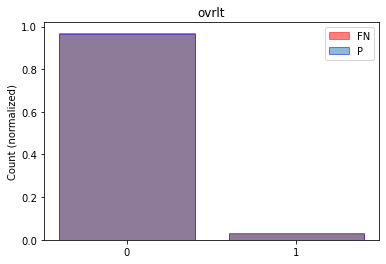

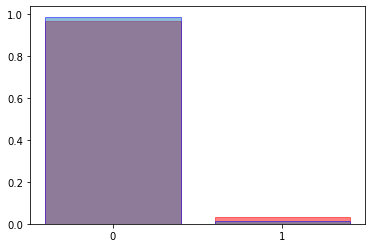

In [49]:
y = []
x = [int(ele) for ele in x_FN['ovrlt']]
for i in range(2):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(2)],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_P['ovrlt']]
for i in range(2):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(2)],y,ec='#0000ff',alpha=0.5)
plt.title('ovrlt')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

y = []
x = [int(ele+0.0001) for ele in x_FP['ovrlt']]
for i in range(2):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(2)],y,color='r',ec='#ff0000',alpha=0.5)
#plt.show()

y = []
x = [int(ele) for ele in x_N['ovrlt']]
for i in range(2):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(2)],y,ec='#0000ff',alpha=0.5)
plt.show()

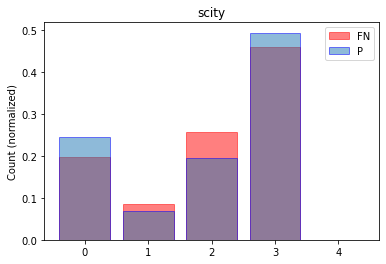

In [50]:
y = []
x = [int(ele+0.0001) for ele in x_FN['scity']*4]
for i in range(5):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(5)],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_P['scity']*4]
for i in range(5):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(5)],y,ec='#0000ff',alpha=0.5)
plt.title('scity')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

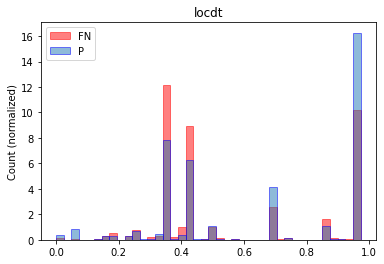

In [51]:
plt.hist(x_FN['stocn'],color='r',ec='#FF0000', alpha=0.5,density=True,bins=40)
plt.hist(x_P['stocn'],ec='#0000FF', alpha=0.5,density=True,bins=40)
plt.title('locdt')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

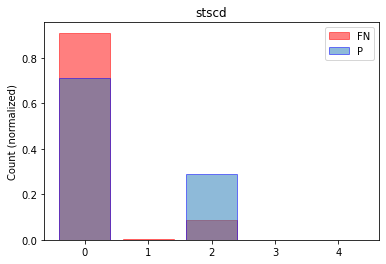

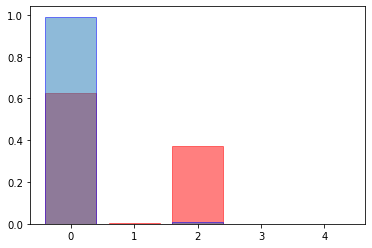

In [52]:
y = []
x = [int(ele+0.0001) for ele in x_FN['stscd']*4]
for i in range(5):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(5)],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele+0.0001) for ele in x_P['stscd']*4]
for i in range(5):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(5)],y,ec='#0000ff',alpha=0.5)
plt.title('stscd')
plt.legend(['FN','P'])
plt.ylabel('Count (normalized)')
plt.show()

y = []
x = [int(ele+0.0001) for ele in x_FP['stscd']*4]
for i in range(5):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(5)],y,color='r',ec='#ff0000',alpha=0.5)


y = []
x = [int(ele+0.0001) for ele in x_N['stscd']*4]
for i in range(5):
    y.append(x.count(i)/len(x))
plt.bar([str(ele) for ele in range(5)],y,ec='#0000ff',alpha=0.5)
plt.show()

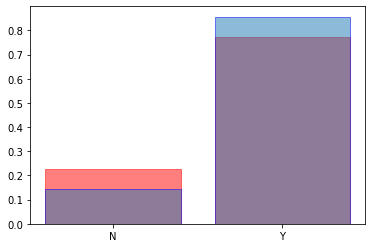

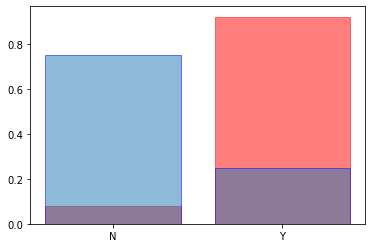

In [53]:
y = []
x = [int(ele) for ele in x_FN['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele) for ele in x_P['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,ec='#0000ff',alpha=0.5)
plt.show()


y = []
x = [int(ele) for ele in x_FP['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,color='r',ec='#ff0000',alpha=0.5)

y = []
x = [int(ele) for ele in x_N['ecfg']]
for i in range(0,2):
    y.append(x.count(i)/len(x))
plt.bar(['N','Y'],y,ec='#0000ff',alpha=0.5)
plt.show()
#網路交易較常被誤認為盜刷